# Calcul de l'indice : scraping

In [56]:
import pandas as pd
import numpy as np
from scipy.stats import gmean

# Liste des mois à traiter
list_mois = [
    "Mai", 
    "Juin", 
    "Juillet",
    "Aout"
    ]

# Chemins vers les fichiers

import platform
if platform.system() == 'Windows':
    base_year_file = 'PB2014.xlsx'  # Fichier de prix de base
    weight_file = 'indice et pond logement ihpc 2014 zone eco.xlsx'  # Fichier de pondération
else:
    base_year_file = '/mnt/d/Bureau/MemoiresStages/Travaux_techniques/Cacul_de_l_indice/PB2014.xlsx'  # Fichier de prix de base
    weight_file = '/mnt/d/Bureau/MemoiresStages/Travaux_techniques/Cacul_de_l_indice/indice et pond logement ihpc 2014 zone eco.xlsx'  # Fichier de pondération

# Importer les fichiers Excel
df_base_year = pd.read_excel(base_year_file)
weights_df = pd.read_excel(weight_file)

# Vérification des colonnes
print("Colonnes dans df_base_year :", df_base_year.columns)
print("Colonnes dans weights_df :", weights_df.columns)

for mois in list_mois:
    # Chemin vers le fichier du mois en cours

    import platform
    if platform.system() == 'Windows':
        current_month_file = f'D:\\Bureau\\MemoiresStages\\Travaux_techniques\\Traitements\\datasets_traites\\{mois}_traitee.xlsx'
    else:
        current_month_file = f'/mnt/d/Bureau/MemoiresStages/Travaux_techniques/Traitements/datasets_traites/{mois}_traitee.xlsx'

    # Importer le fichier Excel du mois en cours
    df_current_month = pd.read_excel(current_month_file)

    # Calculer la moyenne géométrique des loyers par catégorie pour l'année de base
    base_year_geom_prices = df_base_year.groupby('code_var 2014')['loyers de base'].apply(lambda x: gmean(x[x > 0])).reset_index()
    
    # Vérifier l'existence de la colonne 'libellé variété'
    if 'libellé variété' in df_base_year.columns:
        base_year_geom_prices = pd.merge(base_year_geom_prices, df_base_year[['code_var 2014', 'libellé variété']], on='code_var 2014')
    else:
        print("La colonne 'libellé variété' n'existe pas dans df_base_year")

    # Calculer la moyenne géométrique des prix par catégorie pour le mois en cours
    current_month_geom_prices = df_current_month.groupby('code_var 2014')['loyer_mensuel'].apply(lambda x: gmean(x[x > 0])).reset_index()
    current_month_geom_prices.columns = ['code_var 2014', f'prix_{mois.lower()}_2024']

    # Fusionner les données de l'année de base, du mois en cours, et les pondérations
    merged_df = pd.merge(current_month_geom_prices, base_year_geom_prices, on='code_var 2014', how='left')
    merged_df = pd.merge(merged_df, weights_df, on='code_var 2014', how='left')

    # Supprimer les lignes contenant des NaN dans les colonnes 'prix_{mois.lower()}_2024' et 'prix de base'
    merged_df.dropna(subset=[f'prix_{mois.lower()}_2024', 'prix de base'], inplace=True)

    # Calculer l'indice de Laspeyres par catégorie
    merged_df[f'indice_elementaire_{mois.lower()}_2024'] = (merged_df[f'prix_{mois.lower()}_2024'] / merged_df['prix de base'])

    # Sélectionner uniquement les colonnes pertinentes
    merged_df = merged_df[['libellé variété', 'code_var 2014', f'prix_{mois.lower()}_2024', 'prix de base', f'indice_elementaire_{mois.lower()}_2024', 'ponderation national']]

    # Calculer l'indice global de Laspeyres
    laspeyres_index_global = (merged_df[f'indice_elementaire_{mois.lower()}_2024'] * merged_df['ponderation national']).sum() / merged_df['ponderation national'].sum() * 100

    # Afficher les résultats
    print(merged_df)
    print(f"Indice de Laspeyres global pour {mois}: {laspeyres_index_global}")

    # Exporter les résultats vers un fichier Excel si nécessaire
    output_path = f'resultats\\laspeyres_index_{mois.lower()}_results_scraping.xlsx'
    merged_df.to_excel(output_path, index=False)
    
    print(f"Les résultats ont été sauvegardés dans {output_path}")


Colonnes dans df_base_year : Index(['libellé variété', 'code_var 2014', 'prix de base'], dtype='object')
Colonnes dans weights_df : Index(['code_var 2014', 'lib', 'ponderation national', 'Region1 (abidjan)',
       'Region2 (nord)', 'Région3 (centre)', 'Région4 (est)',
       'Région5 (ouest)'],
      dtype='object')
                                     libellé variété  code_var 2014  \
0  Loyer brut d'un appartement moderne de type co...      401000002   
1  Loyer brut mensuel d'une maison de 2 à  3 pièc...      401000005   
2  Loyer brut mensuel d'une maison duplex dans un...      401000006   
3  Loyer d'un logement à  1 chambre à  coucher (S...      401000008   
4  Loyer brut mensuel d'une villa moderne cloturé...      401000010   
5  Loyer brut mensuel d'une villa moderne cloturé...      401000011   

   prix_mai_2024   prix de base  indice_elementaire_mai_2024  \
0  120078.361891   90777.800000                     1.322772   
1  100000.000000   78777.733333                     1.2

## Calcul de l'indice : donnees traditionnelle

In [57]:
import pandas as pd
import numpy as np
from scipy.stats import gmean

# Liste des mois à traiter
list_mois = [
    "Mai", 
    "Juin", 
    "Juillet"
    ]

# Chemins vers les fichiers
base_year_file = 'D:\\Bureau\\MemoiresStages\\Travaux_techniques\\Cacul_de_l_indice\\PB2014.xlsx'  # Fichier de prix de base
traditionnel_file = 'D:\\Bureau\\MemoiresStages\\Travaux_techniques\\Cacul_de_l_indice\\Prix_mois_precedent.xlsx'  # Fichier des données issues des méthodes traditionnelles
weight_file = 'D:\\Bureau\\MemoiresStages\\Travaux_techniques\\Cacul_de_l_indice\\indice et pond logement ihpc 2014 zone eco.xlsx'  # Fichier de pondération

# Importer les fichiers Excel
df_base_year = pd.read_excel(base_year_file)
df_traditionnel = pd.read_excel(traditionnel_file)
weights_df = pd.read_excel(weight_file)

# Vérification des colonnes
print("Colonnes dans df_base_year :", df_base_year.columns)
print("Colonnes dans df_traditionnel :", df_traditionnel.columns)
print("Colonnes dans weights_df :", weights_df.columns)

for mois in list_mois:
    # Identifier la colonne du mois à utiliser
    if mois == "Mai":
        mois_column = "Mai"
    elif mois == "Juin":
        mois_column = "Juin"
    elif mois == "Juillet":
        mois_column = "Juillet"
    
    # Calculer la moyenne géométrique des prix par catégorie pour l'année de base
    base_year_geom_prices = df_base_year.groupby('code_var 2014')['prix de base'].apply(lambda x: gmean(x[x > 0])).reset_index()
    
    # Calculer la moyenne géométrique des prix par catégorie pour le mois en cours
    current_month_geom_prices = df_traditionnel.groupby('code_var 2014')[mois_column].apply(lambda x: gmean(x[x > 0])).reset_index()
    current_month_geom_prices.columns = ['code_var 2014', f'prix_{mois.lower()}_2024']

    # Fusionner les données de l'année de base, du mois en cours, et les pondérations
    merged_df = pd.merge(current_month_geom_prices, base_year_geom_prices, on='code_var 2014', how='left')
    merged_df = pd.merge(merged_df, weights_df[['code_var 2014', 'ponderation national']], on='code_var 2014', how='left')

    # Supprimer les lignes contenant des NaN dans les colonnes 'prix_{mois.lower()}_2024', 'prix de base', et 'ponderation national'
    merged_df.dropna(subset=[f'prix_{mois.lower()}_2024', 'prix de base', 'ponderation national'], inplace=True)

    # Calculer l'indice de Laspeyres par catégorie
    merged_df[f'indice_elementaire_{mois.lower()}_2024'] = (merged_df[f'prix_{mois.lower()}_2024'] / merged_df['prix de base'])

    # Sélectionner uniquement les colonnes pertinentes
    merged_df = merged_df[['code_var 2014', f'prix_{mois.lower()}_2024', 'prix de base', f'indice_elementaire_{mois.lower()}_2024', 'ponderation national']]

    # Calculer l'indice global de Laspeyres en utilisant les pondérations
    laspeyres_index_global = (merged_df[f'indice_elementaire_{mois.lower()}_2024'] * merged_df['ponderation national']).sum() / merged_df['ponderation national'].sum() * 100

    # Afficher les résultats
    print(merged_df)
    print(f"Indice de Laspeyres global tradi pour {mois}: {laspeyres_index_global}")

    # Exporter les résultats vers un fichier Excel si nécessaire
    output_path = f'resultats\\laspeyres_index_{mois.lower()}_results_tradi.xlsx'
    merged_df.to_excel(output_path, index=False)
    
    print(f"Les résultats ont été sauvegardés dans {output_path}")


Colonnes dans df_base_year : Index(['libellé variété', 'code_var 2014', 'prix de base'], dtype='object')
Colonnes dans df_traditionnel : Index(['code_var 2014', 'Code série', 'Libellé', 'Sous-type', 'Mode calcul',
       'Mai', 'Juin', 'Juillet'],
      dtype='object')
Colonnes dans weights_df : Index(['code_var 2014', 'lib', 'ponderation national', 'Region1 (abidjan)',
       'Region2 (nord)', 'Région3 (centre)', 'Région4 (est)',
       'Région5 (ouest)'],
      dtype='object')
   code_var 2014  prix_mai_2024   prix de base  indice_elementaire_mai_2024  \
0      401000002  114122.549096   90777.800000                     1.257164   
1      401000005   96025.173406   78777.733333                     1.218938   
2      401000006  361394.765679  216791.600000                     1.667015   
3      401000008   80638.912529   75451.333333                     1.068754   
4      401000010  234627.650657  233269.230769                     1.005823   
5      401000011  149041.667804  132954.54

# Visualisation

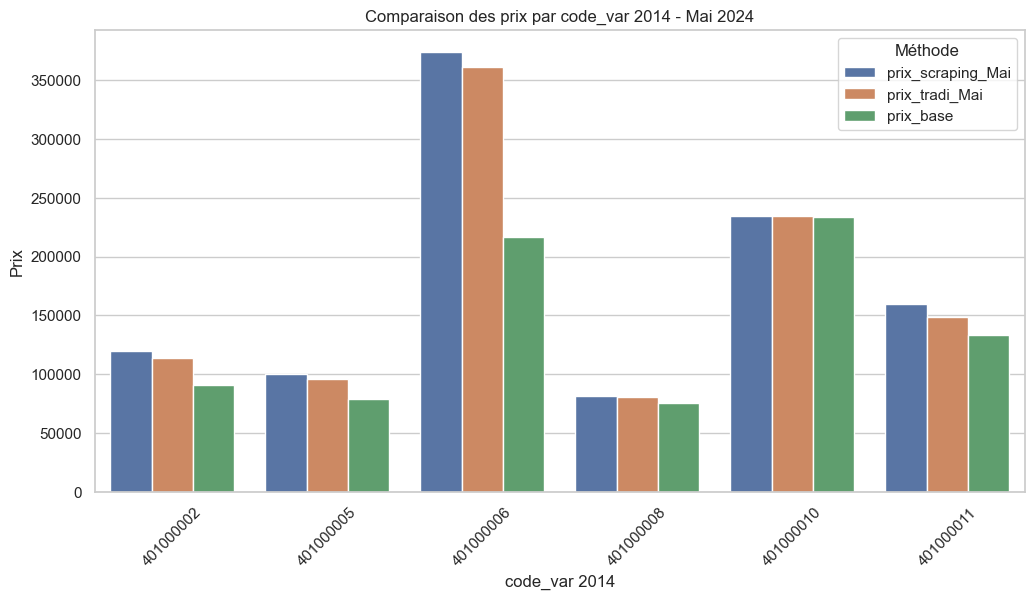

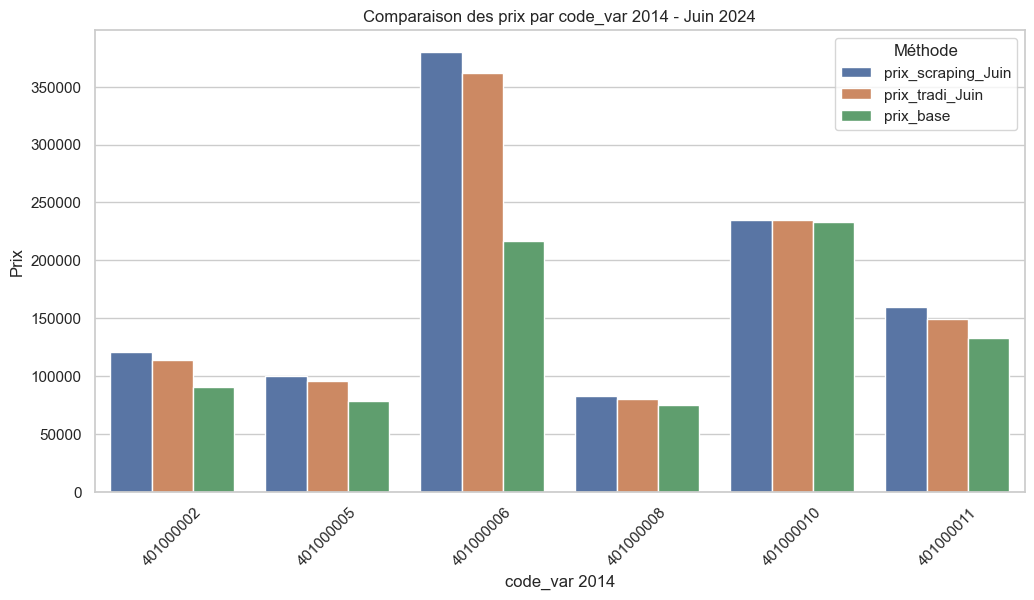

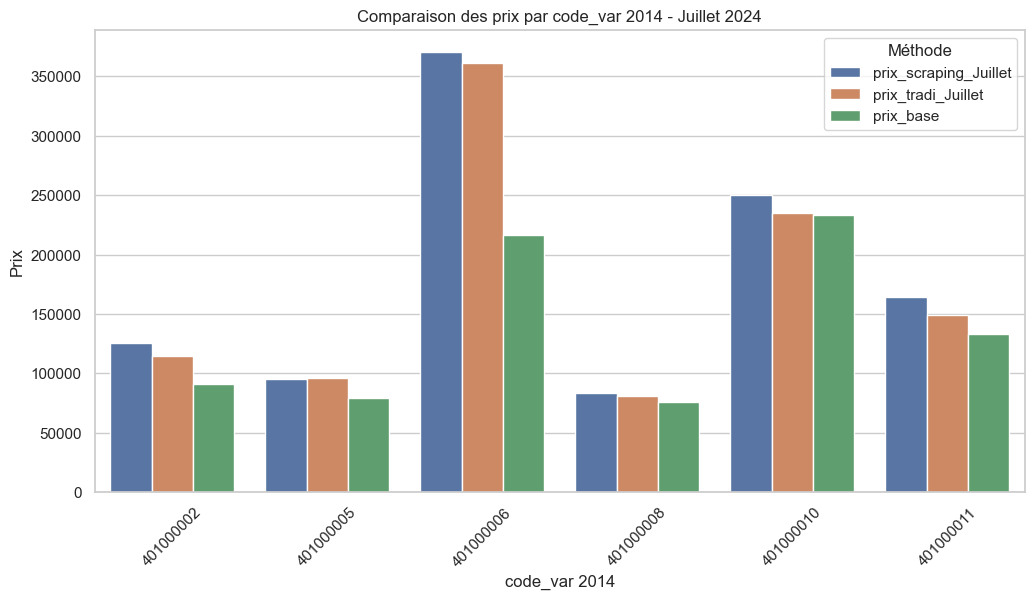

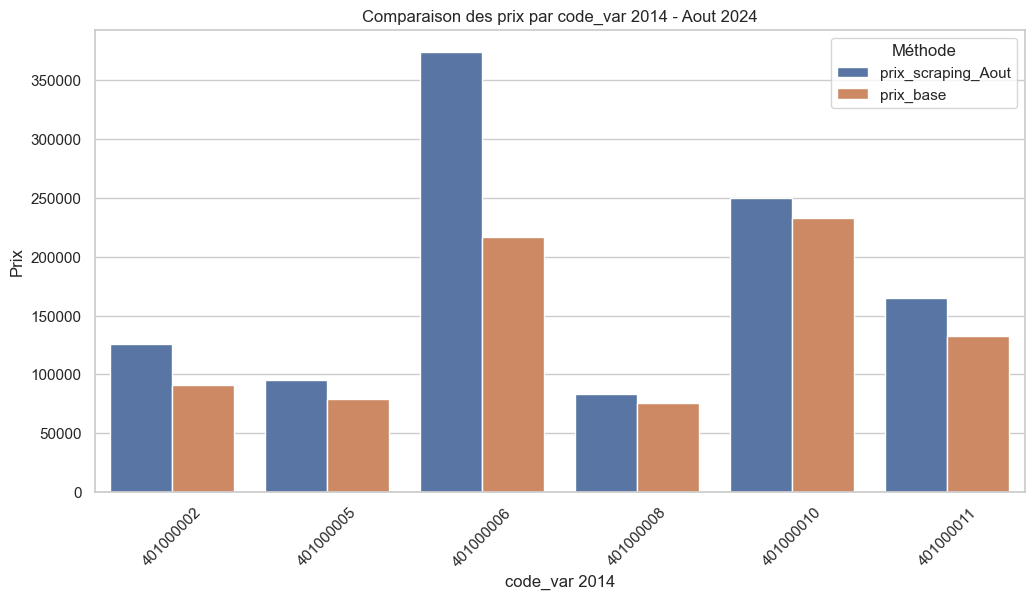

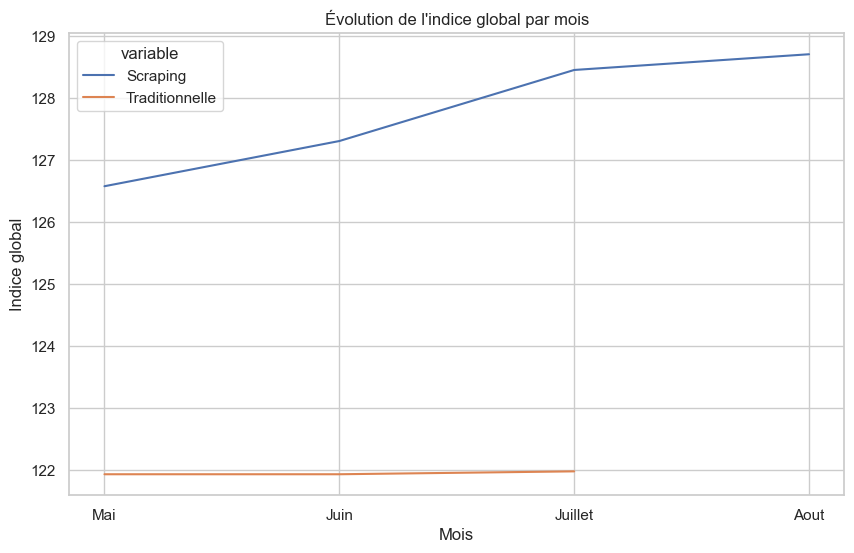

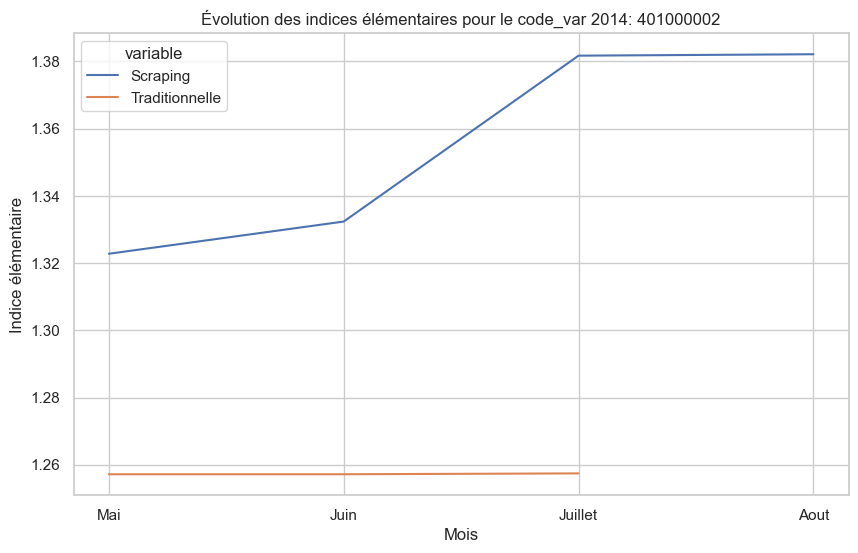

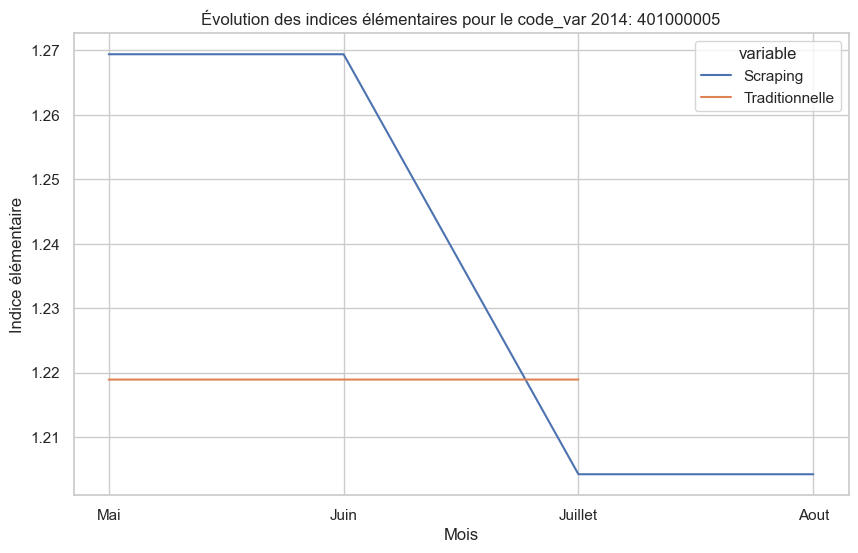

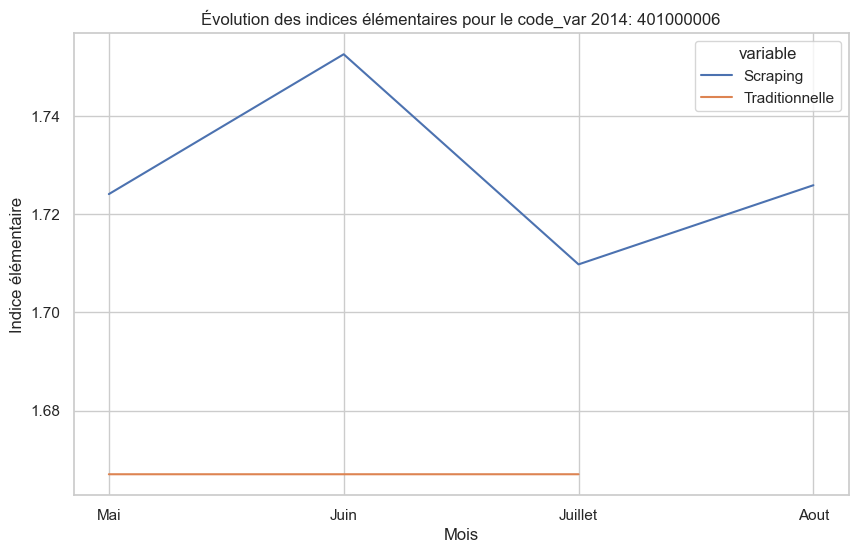

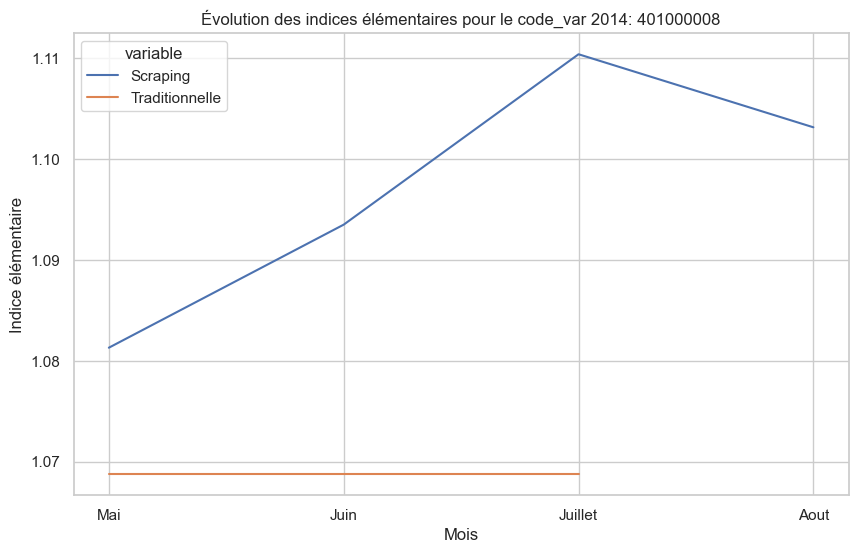

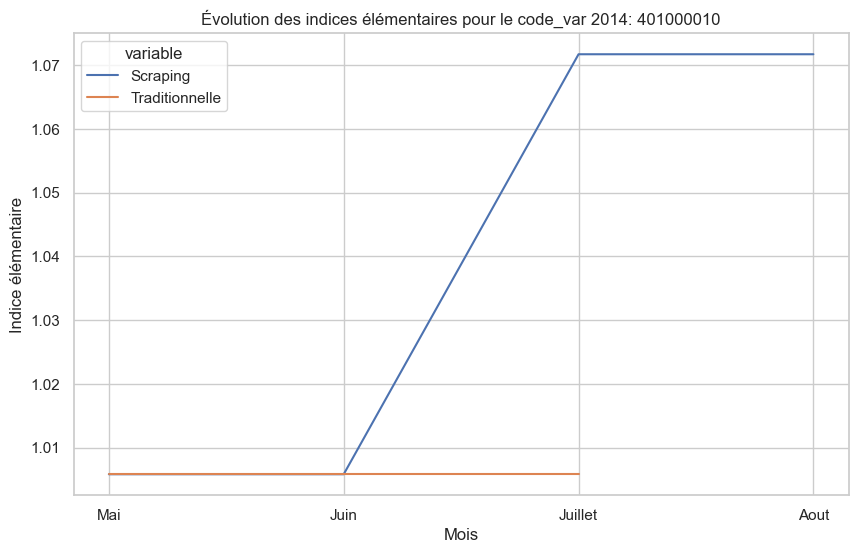

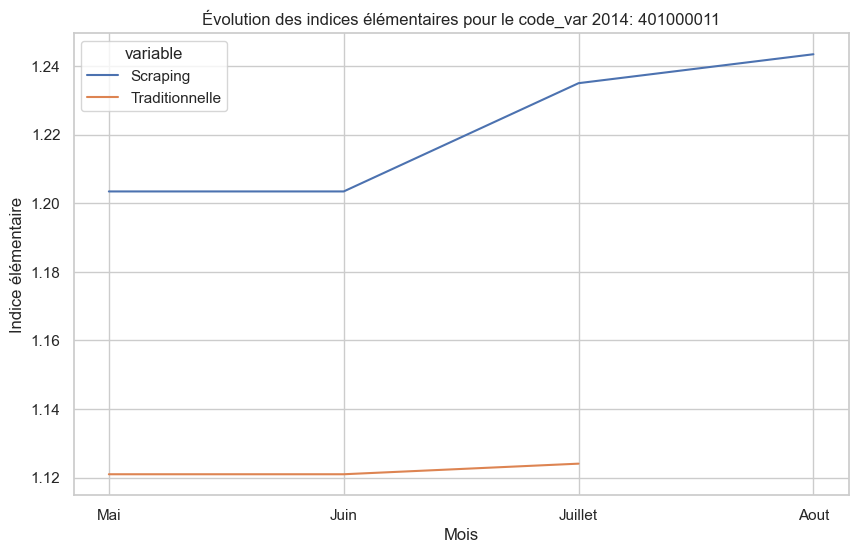

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importer les fichiers de résultats
resultats_scraping_mai = pd.read_excel('resultats/laspeyres_index_mai_results_scraping.xlsx')
resultats_scraping_juin = pd.read_excel('resultats/laspeyres_index_juin_results_scraping.xlsx')
resultats_scraping_juillet = pd.read_excel('resultats/laspeyres_index_juillet_results_scraping.xlsx')
resultats_scraping_aout = pd.read_excel('resultats/laspeyres_index_aout_results_scraping.xlsx')

resultats_tradi_mai = pd.read_excel('resultats/laspeyres_index_mai_results_tradi.xlsx')
resultats_tradi_juin = pd.read_excel('resultats/laspeyres_index_juin_results_tradi.xlsx')
resultats_tradi_juillet = pd.read_excel('resultats/laspeyres_index_juillet_results_tradi.xlsx')

# Recalculer les indices globaux à partir des fichiers de résultats
def recalculer_indice_global(merged_df, mois):
    return (merged_df[f'indice_elementaire_{mois.lower()}_2024'] * merged_df['ponderation national']).sum() / merged_df['ponderation national'].sum() * 100

indice_global_scraping = {
    'Mai': recalculer_indice_global(resultats_scraping_mai, 'mai'),
    'Juin': recalculer_indice_global(resultats_scraping_juin, 'juin'),
    'Juillet': recalculer_indice_global(resultats_scraping_juillet, 'juillet'),
    'Aout': recalculer_indice_global(resultats_scraping_aout, 'aout')
}

indice_global_tradi = {
    'Mai': recalculer_indice_global(resultats_tradi_mai, 'mai'),
    'Juin': recalculer_indice_global(resultats_tradi_juin, 'juin'),
    'Juillet': recalculer_indice_global(resultats_tradi_juillet, 'juillet'),
    # 'Aout': None  # Pas de données pour août
}

# Graphique en barre comparant les loyers issus des deux méthodes et les prix de base par code_var 2014
def visualiser_comparaison_prix(resultats_scraping, resultats_tradi, mois):
    df_comparaison = pd.DataFrame({
        'code_var 2014': resultats_scraping['code_var 2014'],
        'prix_base': resultats_scraping['prix de base'],
        f'prix_scraping_{mois}': resultats_scraping[f'prix_{mois.lower()}_2024']
    })
    
    if resultats_tradi is not None:
        df_comparaison[f'prix_tradi_{mois}'] = resultats_tradi[f'prix_{mois.lower()}_2024']
        df_comparaison = df_comparaison.melt(id_vars='code_var 2014', value_vars=[f'prix_scraping_{mois}', f'prix_tradi_{mois}', 'prix_base'],
                                             var_name='Méthode', value_name='Prix')
    else:
        df_comparaison = df_comparaison.melt(id_vars='code_var 2014', value_vars=[f'prix_scraping_{mois}', 'prix_base'],
                                             var_name='Méthode', value_name='Prix')

    plt.figure(figsize=(12, 6))
    sns.barplot(x='code_var 2014', y='Prix', hue='Méthode', data=df_comparaison)
    plt.title(f'Comparaison des prix par code_var 2014 - {mois} 2024')
    plt.xticks(rotation=45)
    plt.show()

# Courbe montrant l'évolution de l'indice global par mois
def visualiser_evolution_indice_global(indice_scraping, indice_tradi):
    df_evolution = pd.DataFrame({
        'Mois': ['Mai', 'Juin', 'Juillet', 'Aout'],
        'Scraping': [indice_scraping['Mai'], indice_scraping['Juin'], indice_scraping['Juillet'], indice_scraping['Aout']],
        'Traditionnelle': [indice_tradi.get('Mai', None), indice_tradi.get('Juin', None), indice_tradi.get('Juillet', None), None]
    })

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Mois', y='value', hue='variable', 
                 data=pd.melt(df_evolution, ['Mois']))
    plt.title("Évolution de l'indice global par mois")
    plt.ylabel('Indice global')
    plt.show()

# Courbe montrant l'évolution des indices élémentaires par code_var 2014
def visualiser_evolution_indices_elementaires(resultats_scraping, resultats_tradi, code_var):
    df_evolution = pd.DataFrame({
        'Mois': ['Mai', 'Juin', 'Juillet', 'Aout'],
        'Scraping': [
            resultats_scraping_mai.loc[resultats_scraping_mai['code_var 2014'] == code_var, 'indice_elementaire_mai_2024'].values[0],
            resultats_scraping_juin.loc[resultats_scraping_juin['code_var 2014'] == code_var, 'indice_elementaire_juin_2024'].values[0],
            resultats_scraping_juillet.loc[resultats_scraping_juillet['code_var 2014'] == code_var, 'indice_elementaire_juillet_2024'].values[0],
            resultats_scraping_aout.loc[resultats_scraping_aout['code_var 2014'] == code_var, 'indice_elementaire_aout_2024'].values[0]
        ]
    })

    if resultats_tradi is not None:
        df_evolution['Traditionnelle'] = [
            resultats_tradi_mai.loc[resultats_tradi_mai['code_var 2014'] == code_var, 'indice_elementaire_mai_2024'].values[0],
            resultats_tradi_juin.loc[resultats_tradi_juin['code_var 2014'] == code_var, 'indice_elementaire_juin_2024'].values[0],
            resultats_tradi_juillet.loc[resultats_tradi_juillet['code_var 2014'] == code_var, 'indice_elementaire_juillet_2024'].values[0],
            None
        ]

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Mois', y='value', hue='variable', 
                 data=pd.melt(df_evolution, ['Mois']))
    plt.title(f"Évolution des indices élémentaires pour le code_var 2014: {code_var}")
    plt.ylabel('Indice élémentaire')
    plt.show()

# Exécuter les visualisations

# Comparaison des prix pour le mois de Mai
visualiser_comparaison_prix(resultats_scraping_mai, resultats_tradi_mai, "Mai")

# Comparaison des prix pour le mois de Juin
visualiser_comparaison_prix(resultats_scraping_juin, resultats_tradi_juin, "Juin")

# Comparaison des prix pour le mois de Juillet
visualiser_comparaison_prix(resultats_scraping_juillet, resultats_tradi_juillet, "Juillet")

# Comparaison des loyers pour le mois d'Aout (sans méthode traditionnelle)
visualiser_comparaison_prix(resultats_scraping_aout, None, "Aout")

# Évolution de l'indice global
visualiser_evolution_indice_global(indice_global_scraping, indice_global_tradi)

# Évolution des indices élémentaires pour un code_var 2014 spécifique
code_vars = [401000002, 401000005, 401000006, 401000008, 401000010, 401000011]
for code_var in code_vars:
    visualiser_evolution_indices_elementaires(resultats_scraping_mai, resultats_tradi_mai, 401000002)
